In [1]:
import pandas as pd
import numpy as np
import json
import keras
import random
from keras.layers import Dense, LSTM, Dropout, Masking
from keras.models import Sequential, load_model
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

Using TensorFlow backend.


In [2]:
with open('../dati/pad/lines_pad.json', 'r') as f:
    data_lines = json.load(f)

with open('../dati/pad/lines_2_pad.json', 'r') as f:
    data_lines += json.load(f)

for elem in range(len(data_lines)):
    for arr in range(len(data_lines[elem])):
        tmp = []
        for f in range(7):
            tmp.append(data_lines[elem][arr][f])
        data_lines[elem][arr] = tmp

In [3]:
with open('../dati/pad/circles_pad.json', 'r') as f:
    data_circles = json.load(f)

for elem in range(len(data_circles)):
    for arr in range(len(data_circles[elem])):
        tmp = []
        for f in range(7):
            tmp.append(data_circles[elem][arr][f])
        data_circles[elem][arr] = tmp
        

In [4]:
with open('../dati/pad/lines_pad.json', 'r') as f:
    data_lines = json.load(f)

with open('../dati/pad/lines_2_pad.json', 'r') as f:
    data_lines += json.load(f)
    

def generator(data, labels):
    assert len(data) == len(labels)
    while True:
        for elem in range(len(data)):
            #word_array = []
            #for arr in range(len(data[elem])):
            #    tmp = []
            #    for f in range(7):
            #        tmp.append(data[elem][arr][f])
            #    word_array.append(tmp)
            yield np.array(data[elem]), np.array(labels[elem])

g_lines = generator(data_lines, [1] * len(data_lines))

In [5]:
with open('../dati/pad/circles_pad.json', 'r') as f:
    data_circles = json.load(f)
    
g_circles = generator(data_circles, [0] * len(data_circles))

In [6]:
with open('../dati/dati_con_penna/concatenati/pad/dario_1_concat_dario_2_pad.json', 'r') as f:
    data_d = json.load(f)
    
g_dario = generator(data_d[:-3], [1] * 7)
g_dario_test = generator(data_d[-3:], [1] * 3)

In [7]:
with open('../dati/dati_con_penna/concatenati/pad/antonio_1_concat_antonio_2_pad.json', 'r') as f:
    data_a = json.load(f)
    
g_antonio = generator(data_a[:-3], [0] * 8)
g_antonio_test = generator(data_a[-3:], [0] * 3)

In [8]:
with open('../dati/dati_con_penna/concatenati/pad/manuel_1_concat_manuel_2_pad.json', 'r') as f:
    data_t = json.load(f)
    
g_taraz = generator(data_t[:-3], [0] * 7)
g_taraz_test = generator(data_t[-3:], [0] * 3)

In [9]:
with open('../dati/dati_con_penna/concatenati/pad/giovanni_1_concat_giovanni_2_pad.json', 'r') as f:
    data_g = json.load(f)
    
g_giovanni = generator(data_g[:-3], [0] * 5)
g_giovanni_test = generator(data_g[-3:], [0] * 3)

In [10]:
labelled_data_d, labelled_data_g = [], []
for i in range(len(data_d)):
    labelled_data_d.append((data_d[i], 1))

for i in range(len(data_g)):
    labelled_data_g.append((data_g[i], 0))
    
for i in range(len(data_a)):
    labelled_data_g.append((data_a[i], 0))

for i in range(len(data_t)):
    labelled_data_g.append((data_t[i], 0))

In [11]:
labelled_data_dg = labelled_data_d + labelled_data_g  
random.shuffle(labelled_data_dg)

In [12]:
def xy_data(labelled_data):
    x_data, y_labels = [], []
    for i in labelled_data:
        x_data.append(i[0])
        y_labels.append(i[1])
        
    return np.array(x_data), np.array(y_labels)

data_dg, label_dg = xy_data(labelled_data_dg)
print(data_dg.shape)

(196, 600, 7)


In [13]:
def mix_generator(g1, g2, batch_size):
    while True:
        batch = []
        label = []
        for _ in range(batch_size // 2):
            tmp = next(g1)
            batch.append(tmp[0])
            label.append(tmp[1])
            tmp = next(g2)
            batch.append(tmp[0])
            label.append(tmp[1])
        print(np.array(label).shape)
        yield np.array(batch), np.array(label)

g_mix = mix_generator(g_lines, g_circles, 10)
g_dario_giovanni = mix_generator(g_dario, g_giovanni, 10)
g_dario_antonio = mix_generator(g_dario, g_antonio, 10)
g_dario_taraz = mix_generator(g_dario, g_taraz, 10)
g_dario_giovanni_antonio = mix_generator(g_dario_giovanni, g_dario_antonio, 10)
g_dario_tutti = mix_generator(g_dario_giovanni_antonio, g_dario_taraz, 10)

In [14]:
def generator_one_against_all(path_genuine, paths_impostors, batch_size):
    with open(path_genuine, 'r') as f:
        genuine_data = json.load(f)
        
    train_ratio = round(len(genuine_data) / 5)
    assert len(genuine_data[:-train_ratio]) + len(genuine_data[-train_ratio:]) == len(genuine_data)
    genuine_generator = generator(genuine_data[:-train_ratio], [1] * (len(genuine_data) - train_ratio))
    genuine_generator_test = generator(genuine_data[-train_ratio:], [1] * train_ratio)
    
    generator_all = genuine_generator
    generator_all_test = genuine_generator_test
    
    for path in paths_impostors:
        with open(path, 'r') as f:
            impostor_data = json.load(f)
        train_ratio = round(len(impostor_data) / 5)
        assert len(impostor_data[:-train_ratio]) + len(impostor_data[-train_ratio:]) == len(impostor_data)
        generator_all = mix_generator(generator_all, generator(impostor_data[:-train_ratio], [0] * (len(impostor_data) - train_ratio)), batch_size)
        generator_all_test = mix_generator(generator_all_test, generator(impostor_data[-train_ratio:], [0] * train_ratio), batch_size)
        
    return generator_all, generator_all_test

impostors = ['../dati/pad/giovanni_pad.json', '../dati/pad/taraz_pad.json']
g_dario_impostors, g_dario_impostors_test = generator_one_against_all('../dati/pad/dario_pad.json', impostors, 10)

In [15]:
def create_model():
    model = Sequential()
    model.add(Masking(mask_value=0.0))
    model.add(LSTM(input_shape=(600, 7), units=200, activation="sigmoid", return_sequences=True, recurrent_activation="hard_sigmoid"))
    model.add(LSTM(units=200, activation="sigmoid", return_sequences=False, recurrent_activation="hard_sigmoid"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [16]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=4,
                                 steps_per_epoch=140,
                                 validation_split=0.2,
                                 validation_steps=36,
                                 verbose=1)

In [17]:
#plot_model(model_dario, show_shapes=True, to_file='lstm_dropout_model.png')

In [18]:
#hist = model_dario.fit_generator(g_dario_impostors, epochs=5, steps_per_epoch=42)


In [19]:
#hist = model_dario.fit(x = data_dg, y = label_dg, epochs=40, steps_per_epoch=33, validation_split=0.33, validation_steps=65)

out = cross_val_score(neural_network, data_dg, label_dg, cv=10,)

Train on 140 samples, validate on 36 samples
Epoch 1/4
140/140 [==============================] - 153s 1s/step - loss: 0.2777 - acc: 0.8930 - val_loss: 0.0777 - val_acc: 0.9722
Epoch 2/4
140/140 [==============================] - 153s 1s/step - loss: 0.1186 - acc: 0.9773 - val_loss: 0.0593 - val_acc: 0.9722
Epoch 3/4
140/140 [==============================] - 152s 1s/step - loss: 0.0811 - acc: 0.9896 - val_loss: 0.0217 - val_acc: 0.9722
Epoch 4/4
20/20 [==============================] - 0s 15ms/step
Train on 140 samples, validate on 36 samples
Epoch 1/4
140/140 [==============================] - 151s 1s/step - loss: 0.2834 - acc: 0.8912 - val_loss: 0.2220 - val_acc: 0.9444
Epoch 2/4
140/140 [==============================] - 150s 1s/step - loss: 0.1025 - acc: 0.9796 - val_loss: 0.3185 - val_acc: 0.9444
Epoch 3/4
140/140 [==============================] - 149s 1s/step - loss: 0.1936 - acc: 0.9753 - val_loss: 0.1633 - val_acc: 0.9444
Epoch 4/4
20/20 [==============================] - 0s 

In [42]:
#out
#!git config --global user.email "antoniomusolino007@gmail.com"
!git add .
!git commit -m 'aggiunto grafico cross validation'
!git push 
print(out)
out.mean()

[master 7363641] aggiunto grafico cross validation
 2 files changed, 47 insertions(+), 5 deletions(-)
 create mode 100644 LSTM/K-folder-performance.png
Git 2.0 from 'matching' to 'simple'. To squelch this message
and maintain the traditional behavior, use:

  git config --global push.default matching

To squelch this message and adopt the new behavior now, use:

  git config --global push.default simple

When push.default is set to 'matching', git will push local branches
to the remote branches that already exist with the same name.

Since Git 2.0, Git defaults to the more conservative 'simple'
behavior, which only pushes the current branch to the corresponding
remote branch that 'git pull' uses to update the current branch.

See 'git help config' and search for 'push.default' for further information.
(the 'simple' mode was introduced in Git 1.7.11. Use the similar mode
'current' instead of 'simple' if you sometimes use older versions of Git)

Counting objects: 5, done.
Delta compressi

0.8944736897945404

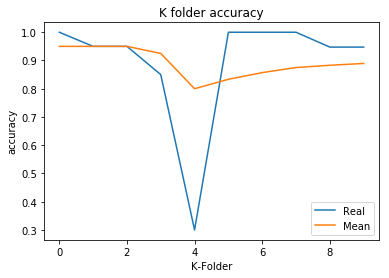

In [41]:
mean = [0]*10
mean[0] = out[1]
for i in range(1,len(out)):
    mean[i] = ((mean[i-1] )*i + out[i])/(i+1)

plt.plot(out)
plt.plot(mean)
plt.title('K folder accuracy')
plt.ylabel('accuracy')
plt.xlabel('K-Folder')
plt.legend(['Real', 'Mean'], loc='lower right')
plt.savefig('./K-folder-performance')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./model_accuracy_40Epoch_scaled',quality=100,)

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('./model_loss_40Epoch_scaled')

In [ ]:
model_dario.save("model_dario.h5")
del model_dario

In [ ]:
model_dario_reloaded = load_model("model_dario.h5")

In [ ]:
out_dario_reloaded = model_dario_reloaded.evaluate_generator(g_dario_test, verbose=1, steps=3)

out_dario_reloaded